## Read overlapping images from Proba-V and Sentinel-2

Given a Sentinel-2 GeoTIFF file from the CloudSEN12 dataset (`cloudsen12/high/point_0317/20190207T172509_20190207T173213_T13QGG/S2L1C.tif`) and a Proba-V image we will show how to read the overlapping regions of those two using the georeader package.


First we will download the Proba-V image

In [1]:
from georeader.readers import download_pv_product

link_pv_product = "https://www.vito-eodata.be/PDF/datapool/Free_Data/PROBA-V_100m/S1_TOA_100_m_C1/2019/2/9/PV_S1_TOA-20190209_100M_V101/PROBAV_S1_TOA_X07Y05_20190209_100M_V101.HDF5"
filename_down = download_pv_product.download_product(link_pv_product)

File PROBAV_S1_TOA_X07Y05_20190209_100M_V101.HDF5 exists. It won't be downloaded again


In [2]:
filename_down

'PROBAV_S1_TOA_X07Y05_20190209_100M_V101.HDF5'

## Inspect Proba-V products

Prova-V images are very large (10080x10080 pixels). Therefore we should avoid read them all in memory if possible.

In [3]:
%%time

from georeader.readers import probav_image_operational

toa_reader = probav_image_operational.ProbaVRadiometry(filename_down, level_name="LEVEL3")
toa_reader

CPU times: user 214 ms, sys: 28.4 ms, total: 242 ms
Wall time: 311 ms


 
         File: PROBAV_S1_TOA_X07Y05_20190209_100M_V101.HDF5
         Transform: | 0.00, 0.00,-110.00|
| 0.00,-0.00, 25.00|
| 0.00, 0.00, 1.00|
         Shape: 10080, 10080
         Resolution: (0.000992063492063, 0.000992063492063)
         Bounds: (-110.0, 15.00000000000496, -100.00000000000496, 25.0)
         CRS: {'init': 'epsg:4326'}
         Level: LEVEL3
         TOA/TOC: TOA
         Resolution name : 100M
        

## Warning!! 

To read the Proba-V image content the `h5py` package requires an special compression. If installed from conda this compressor is not available. Therefore, re-install h5py from pip if the following cell fails!

`pip install h5py --no-deps --ignore-installed`


In [4]:
toa_reader.assert_can_be_read()
# If this raises an error reinstall h5py with pip and reset the notebook:
# pip install h5py --no-deps --ignore-installed

## Read Sentinel-2 file of the cloudSEN12 dataset

In [5]:
from georeader.rasterio_reader import RasterioReader

s2reader = RasterioReader("S2L1C.tif")
s2reader

 
         Paths: ['S2L1C.tif']
         Transform: | 10.00, 0.00, 770950.00|
| 0.00,-10.00, 2696720.00|
| 0.00, 0.00, 1.00|
         Shape: (13, 509, 509)
         Resolution: (10.0, 10.0)
         Bounds: (770950.0, 2691630.0, 776040.0, 2696720.0)
         CRS: EPSG:32613
         nodata: None
         fill_value_default: 0
        

Band names are stored in the `descriptions` attribute

In [6]:
s2reader.descriptions

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B10',
 'B11',
 'B12']

Set the reader to read the SWIR, NIR, RED bands of Sentinel-2

In [7]:
s2reader.set_indexes_by_name(["B2","B4", "B8","B11"])
s2reader

 
         Paths: ['S2L1C.tif']
         Transform: | 10.00, 0.00, 770950.00|
| 0.00,-10.00, 2696720.00|
| 0.00, 0.00, 1.00|
         Shape: (4, 509, 509)
         Resolution: (10.0, 10.0)
         Bounds: (770950.0, 2691630.0, 776040.0, 2696720.0)
         CRS: EPSG:32613
         nodata: None
         fill_value_default: 0
        

In [8]:
# Read image in memory
s2reader_memory = s2reader.load()
s2reader_memory.values

array([[[ 998.,  976.,  954., ...,  948.,  879.,  995.],
        [1013.,  956.,  942., ..., 1181., 1133., 1080.],
        [1028.,  957.,  989., ..., 1125., 1173., 1257.],
        ...,
        [1596., 1579., 1472., ..., 1203., 1256., 1191.],
        [1548., 1433., 1360., ..., 1296., 1325., 1225.],
        [1550., 1539., 1377., ..., 1406., 1371., 1298.]],

       [[1032., 1015.,  899., ...,  930.,  848.,  988.],
        [1045.,  948.,  891., ..., 1296., 1209., 1164.],
        [1119.,  918.,  988., ..., 1233., 1334., 1502.],
        ...,
        [2360., 2318., 2084., ..., 1491., 1541., 1490.],
        [2305., 2049., 1953., ..., 1650., 1685., 1476.],
        [2366., 2126., 2023., ..., 1815., 1730., 1642.]],

       [[1387., 1377., 1191., ..., 1262., 1103., 1283.],
        [1374., 1262., 1195., ..., 1635., 1580., 1559.],
        [1432., 1319., 1351., ..., 1501., 1747., 1885.],
        ...,
        [2563., 2576., 2363., ..., 1943., 1975., 1939.],
        [2527., 2290., 2204., ..., 2173., 208

## Read Proba-V image within the bounds of the Sentinel-2

In [9]:
%%time
from georeader import read

tile_read = read.read_from_bounds(toa_reader, bounds=s2reader.bounds, crs_bounds=s2reader.crs,
                                  pad_add=(50, 50))
tile_read

CPU times: user 9.82 ms, sys: 574 µs, total: 10.4 ms
Wall time: 17.2 ms


 
         File: PROBAV_S1_TOA_X07Y05_20190209_100M_V101.HDF5
         Transform: | 0.00, 0.00,-102.38|
| 0.00,-0.00, 24.41|
| 0.00, 0.00, 1.00|
         Shape: 148, 152
         Resolution: (0.000992063492063, 0.000992063492063)
         Bounds: (-102.3799603174641, 24.263888888889255, -102.22916666667052, 24.41071428571458)
         CRS: {'init': 'epsg:4326'}
         Level: LEVEL3
         TOA/TOC: TOA
         Resolution name : 100M
        

In [10]:
tile_read_memory = tile_read.load()
tile_read_memory.values

array([[[0.1295, 0.1285, 0.1255, ..., 0.151 , 0.152 , 0.149 ],
        [0.1315, 0.1305, 0.129 , ..., 0.15  , 0.15  , 0.1515],
        [0.131 , 0.135 , 0.137 , ..., 0.1495, 0.1475, 0.143 ],
        ...,
        [0.2445, 0.2405, 0.238 , ..., 0.1335, 0.1365, 0.136 ],
        [0.2415, 0.238 , 0.233 , ..., 0.138 , 0.131 , 0.1355],
        [0.237 , 0.2385, 0.234 , ..., 0.135 , 0.1275, 0.1365]],

       [[0.1205, 0.1185, 0.119 , ..., 0.1725, 0.1745, 0.176 ],
        [0.1185, 0.1205, 0.1275, ..., 0.1705, 0.1715, 0.172 ],
        [0.1265, 0.1465, 0.155 , ..., 0.167 , 0.164 , 0.163 ],
        ...,
        [0.249 , 0.2455, 0.243 , ..., 0.116 , 0.1255, 0.122 ],
        [0.245 , 0.2395, 0.236 , ..., 0.1325, 0.124 , 0.1225],
        [0.2385, 0.2325, 0.2255, ..., 0.123 , 0.1115, 0.125 ]],

       [[0.156 , 0.154 , 0.153 , ..., 0.227 , 0.2335, 0.229 ],
        [0.153 , 0.1575, 0.165 , ..., 0.2245, 0.2245, 0.2305],
        [0.1625, 0.18  , 0.196 , ..., 0.2225, 0.22  , 0.218 ],
        ...,
        [0.2

CPU times: user 659 ms, sys: 22.8 ms, total: 682 ms
Wall time: 746 ms


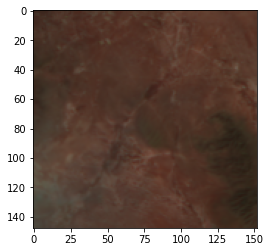

In [11]:
%%time
import numpy as np
import matplotlib.pyplot as plt

# SWIR, NIR, RED composite
rgb_show = np.transpose(tile_read.values[:0:-1],(1,2,0))
plt.imshow(rgb_show)

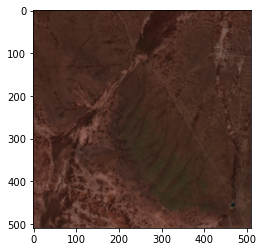

In [12]:
plt.imshow(np.clip(s2reader_memory.values[:0:-1]/10_000,0,1).transpose((1,2,0)))

## Reproject Proba-V and Sentinel-2

First we will reproject the Proba-V image to the UTM crs of Sentinel-2 at a 100m resolution

In [13]:
probav_100m_utm = read.read_reproject(toa_reader, bounds=s2reader.bounds, dst_crs=s2reader.crs,
                                      resolution_dst_crs=100)
probav_100m_utm

 
         Transform: | 100.00, 0.00, 770950.00|
| 0.00,-100.00, 2696720.00|
| 0.00, 0.00, 1.00|
         Shape: (4, 51, 51)
         Resolution: (100.0, 100.0)
         Bounds: (770950.0, 2691620.0, 776050.0, 2696720.0)
         CRS: EPSG:32613
         fill_value_default: -0.0005
        

Secondly we will reproject Sentinel-2 to 100m but we will use an anti-aliasing filter to avoid aliasing artifacts.

In [14]:
s2reader_memory.set_dtype(np.float32) # Convert to float to avoid resampling errors!

s2_100m = read.resize(s2reader_memory, resolution_dst=100, anti_aliasing=True)
s2_100m

 
         Transform: | 100.00, 0.00, 770950.00|
| 0.00,-100.00, 2696720.00|
| 0.00, 0.00, 1.00|
         Shape: (4, 51, 51)
         Resolution: (100.0, 100.0)
         Bounds: (770950.0, 2691620.0, 776050.0, 2696720.0)
         CRS: EPSG:32613
         fill_value_default: 0
        

Text(0.5, 1.0, 'Sentinel-2 10m NIR/RED/BLUE')

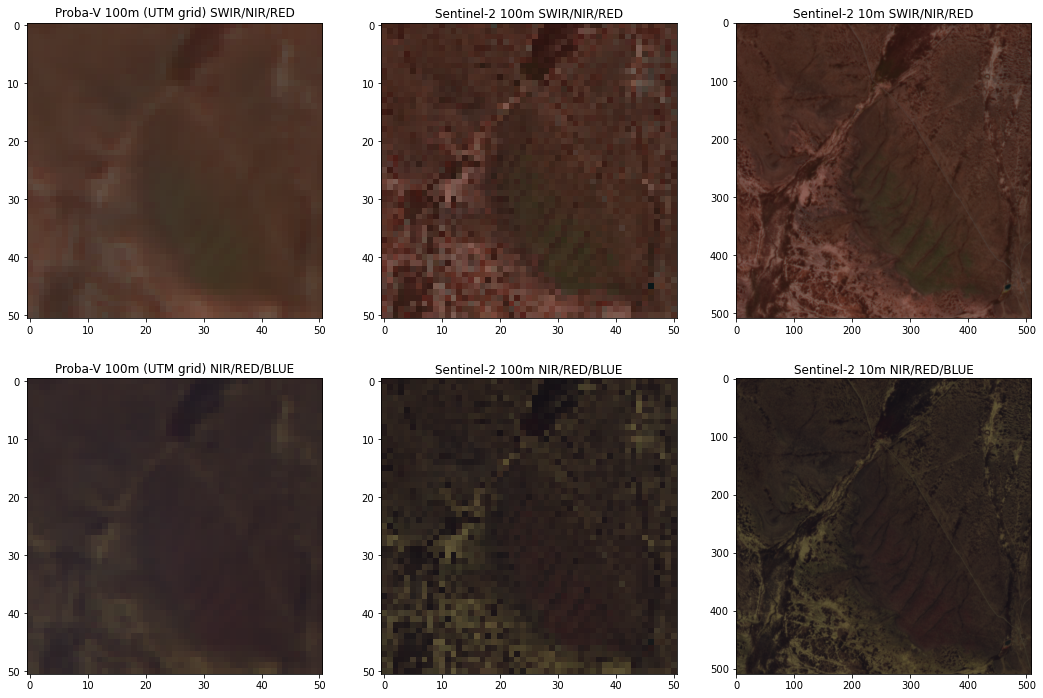

In [15]:
fig, ax = plt.subplots(2,3,figsize=(18,12))
ax[0,0].imshow(probav_100m_utm.values[:0:-1].transpose((1,2,0)))
ax[0,0].set_title("Proba-V 100m (UTM grid) SWIR/NIR/RED")
ax[0,1].imshow(np.clip(s2_100m.values[:0:-1].transpose((1,2,0))/10_000,0,1))
ax[0,1].set_title("Sentinel-2 100m SWIR/NIR/RED")
ax[0,2].imshow(np.clip(s2reader_memory.values[:0:-1].transpose((1,2,0))/10_000,0,1))
ax[0,2].set_title("Sentinel-2 10m SWIR/NIR/RED")

ax[1,0].imshow(probav_100m_utm.values[-2::-1].transpose((1,2,0)))
ax[1,0].set_title("Proba-V 100m (UTM grid) NIR/RED/BLUE")
ax[1,1].imshow(np.clip(s2_100m.values[-2::-1].transpose((1,2,0))/10_000,0,1))
ax[1,1].set_title("Sentinel-2 100m NIR/RED/BLUE")
ax[1,2].imshow(np.clip(s2reader_memory.values[-2::-1].transpose((1,2,0))/10_000,0,1))
ax[1,2].set_title("Sentinel-2 10m NIR/RED/BLUE")